Imports

In [1]:
from astropy import units as u
from astropy import constants as c
from astropy.modeling.models import BlackBody, PowerLaw1D
from astropy.io import fits

import numpy as np

import matplotlib.pyplot as plt

from utils.frd import elex_transfcnl
from utils.fsl import calc_responsivity, produce_spectra, read_coadd
import utils.util as util

import h5py

Original inteferogram

Time: 41585542646180000
MTM length: 0
MTM speed: 0


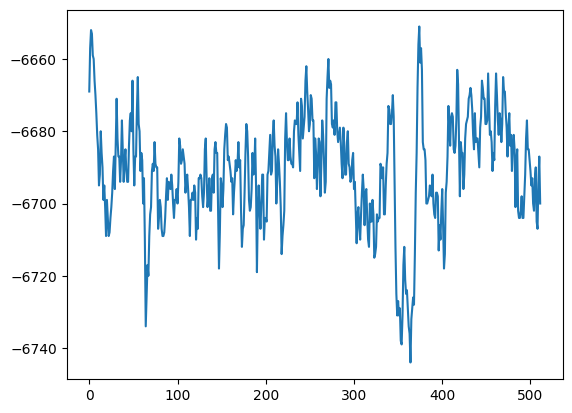

In [2]:
erecno = 170
ifg_ind = 550_000  # this is a pretty good one
# ifg_ind = 55_000

data_orig = h5py.File(
        "/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_sdf_new.h5"
    )
data_ll = data_orig["fdq_sdf_ll"]
original_ifg = data_ll["ifg_data/ifg"][ifg_ind]

eng_time = data_ll["dq_data/eng_time"][ifg_ind]
print(f"Time: {eng_time}")

mtm_length = data_ll['sci_head/mtm_length'][ifg_ind]
print(f"MTM length: {mtm_length}")
mtm_speed = data_ll['sci_head/mtm_speed'][ifg_ind]
print(f"MTM speed: {mtm_speed}")

plt.plot(original_ifg)
plt.show()

In [3]:
data_orig_eng = h5py.File(
        "/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_eng_new.h5"
    )

arr = list(data_orig_eng["ct_head/time"])

try:
    eng_id = arr.index(eng_time)
    print(eng_id)
except ValueError:
    print("Engineering data not available for this time.")


xmit_mtm_len = data_orig_eng["chan/xmit_mtm_len"][eng_id]
print(f"Xmit MTM length: {xmit_mtm_len}")
xmit_mtm_speed = data_orig_eng["chan/xmit_mtm_speed"][eng_id]
print(f"Xmit MTM speed: {xmit_mtm_speed}")

546460
Xmit MTM length: [0 0 0 0]
Xmit MTM speed: [0 0 0 0]


Range definition

In [4]:
f_nyquist = 145.212 / u.cm

nu = np.arange(320)*(f_nyquist/320) + 2 / u.cm
nu_lowf = nu[:43]
dnu = nu[1] - nu[0]

dGHz = dnu.to(u.GHz, equivalencies=u.spectral())
f_lowf = np.arange(43) * dGHz + 30 * u.GHz
f_GHz = np.arange(512) * dGHz + 30 * u.GHz

print(f"Low frequency range: {f_lowf[0]} - {f_lowf[-1]}")

x_max = 1.22 * u.cm
dx = x_max / 512
x = np.arange(512) * dx
x0 = x[360]

Low frequency range: 30.0 GHz - 601.3766941456347 GHz


In [5]:
# # dGHz = 17 * u.GHz  # Taken from Explanatory Supplement, page 14 for LRES
# # dGHz = 4.2 * u.GHz  # Taken from Explanatory Supplement, page 14 for hres
# dGHz = 13.604162 * u.GHz
# f_GHz = np.arange(0, 43) * dGHz + 68.020812
# # f_GHz = np.arange(1, 513) * dGHz

# dnu = dGHz.to("cm-1", equivalencies=u.spectral())
# # dnu = 0.57 / u.cm
# nu = np.arange(1, 513) * dnu

# # dGHz = dnu.to("GHz", equivalencies=u.spectral())
# # f_GHz = np.arange(1, 513) * dGHz

# # x_max = dnu.to("cm", equivalencies=u.spectral())
# x_max = 1.22 * u.cm
# dx = x_max / 512
# x = np.arange(1, 513) * dx

# # dnu = 1 / x_max
# # nu = np.arange(1, 513) * dnu
# print(max(nu))

# dGHz = dnu.to("GHz", equivalencies=u.spectral())
# f_GHz = np.arange(1, 513) * dGHz

# # x = np.arange(1, 513)

# # nu = 1 / x
# # nu_max = max(nu)
# # nu = np.arange(1, 513) * nu_max / 512

# # x0 = (max(x) + min(x)) / 2
# x0 = x[360] # page 37 of the explanatory supplement for LLSS RLSS

Forcing the maximum value for cm$^{-1}$ to be 21

In [6]:
# nu_min = 2 / u.cm
# nu_max = 21 / u.cm
# nu = np.linspace(nu_min, nu_max, 512)
# dnu = nu[1] - nu[0]
# print(dnu)

# x_max = dnu.to("cm", equivalencies=u.spectral())
# x = np.linspace(0, x_max, 512)
# x0 = x[360]

# dGHz = dnu.to("GHz", equivalencies=u.spectral())
# f_GHz = np.linspace(1e-5, 1, 512) * dGHz

# print(dGHz)

In [7]:
# pad to 512 before fourier transform?

def transform_to_ifg(sky, bb_ical):
    # sky = np.pad(sky, (0, 512 - len(sky)))
    # bb_ical = np.pad(bb_ical, (0, 512 - len(bb_ical)))

    sky = sky.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_lowf))
    bb_ical = bb_ical.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_lowf))

    diff = sky - bb_ical

    ifg = np.zeros(len(x))

    for i in range(len(x)):
        ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu_lowf.value * (x[i].value - x0.value)))
        # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))

    ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

    return diff, ifg

## Sky

CMB monopole

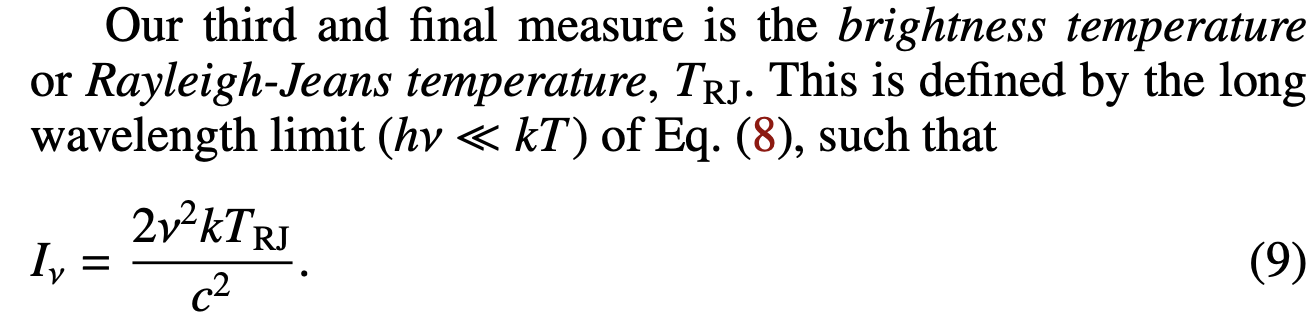
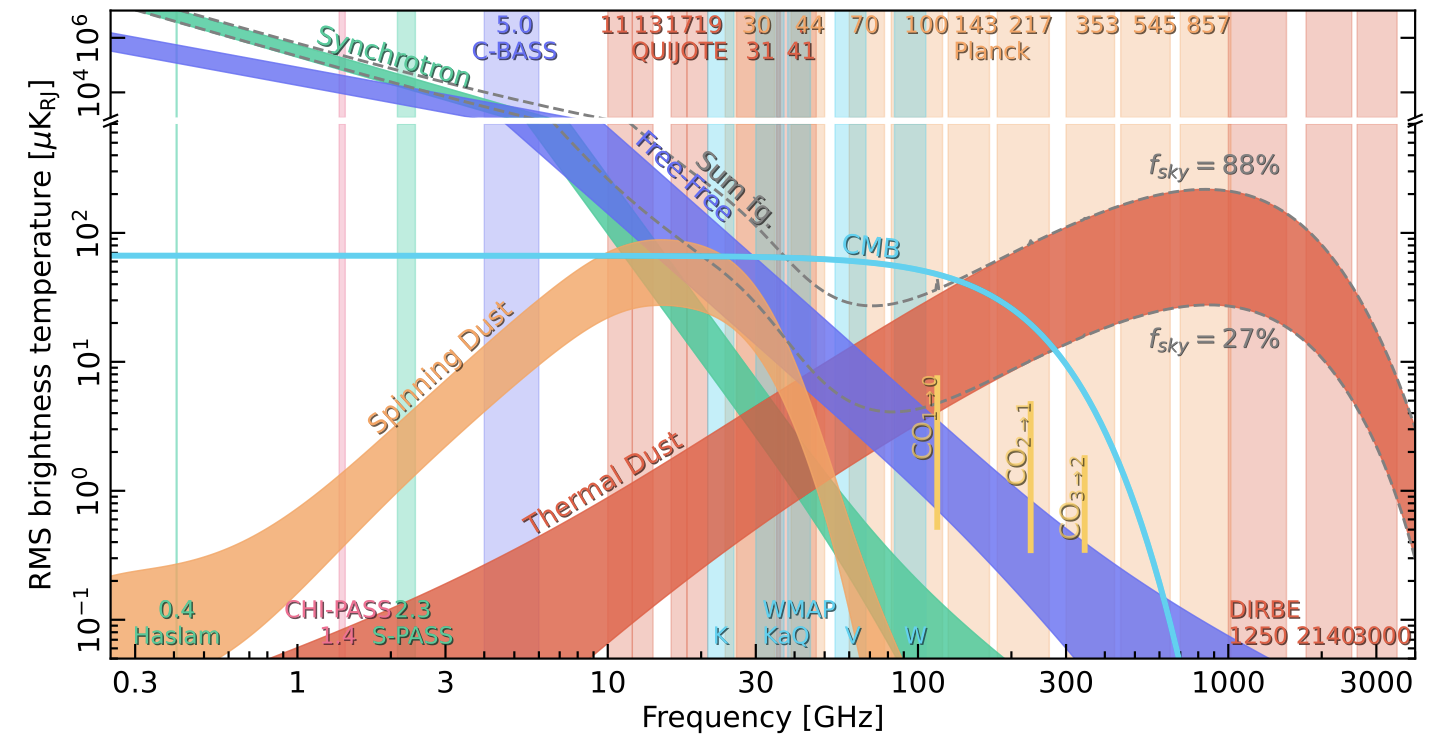
(BeyondPlanck I. Global Bayesian analysis of the Planck Low Frequency Instrument data)

In [8]:
t_cmb = 2.72548 * u.K  # Fixsen, 2009

bb_cmb = BlackBody(t_cmb)
bb_cmb = bb_cmb(f_lowf)
# bb_cmb = bb_cmb.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.spectral_density(f_GHz))
bb_cmb = bb_cmb.to(u.uK, equivalencies=u.brightness_temperature(f_lowf))

t_ical = (0.1 * data_orig_eng["en_analog/grt/a_hi_ical"][eng_id] + 0.9 * data_orig_eng["en_analog/grt/b_hi_ical"][eng_id]) * u.K

print(t_ical)

bb_ical = BlackBody(t_ical)
bb_ical = 0.96 * bb_ical(f_lowf)
# bb_ical = bb_ical.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.spectral_density(f_GHz))
bb_ical = bb_ical.to(u.uK, equivalencies=u.brightness_temperature(f_lowf))

[2.7514012] K


In [9]:
diff, ifg = transform_to_ifg(bb_cmb, bb_ical)

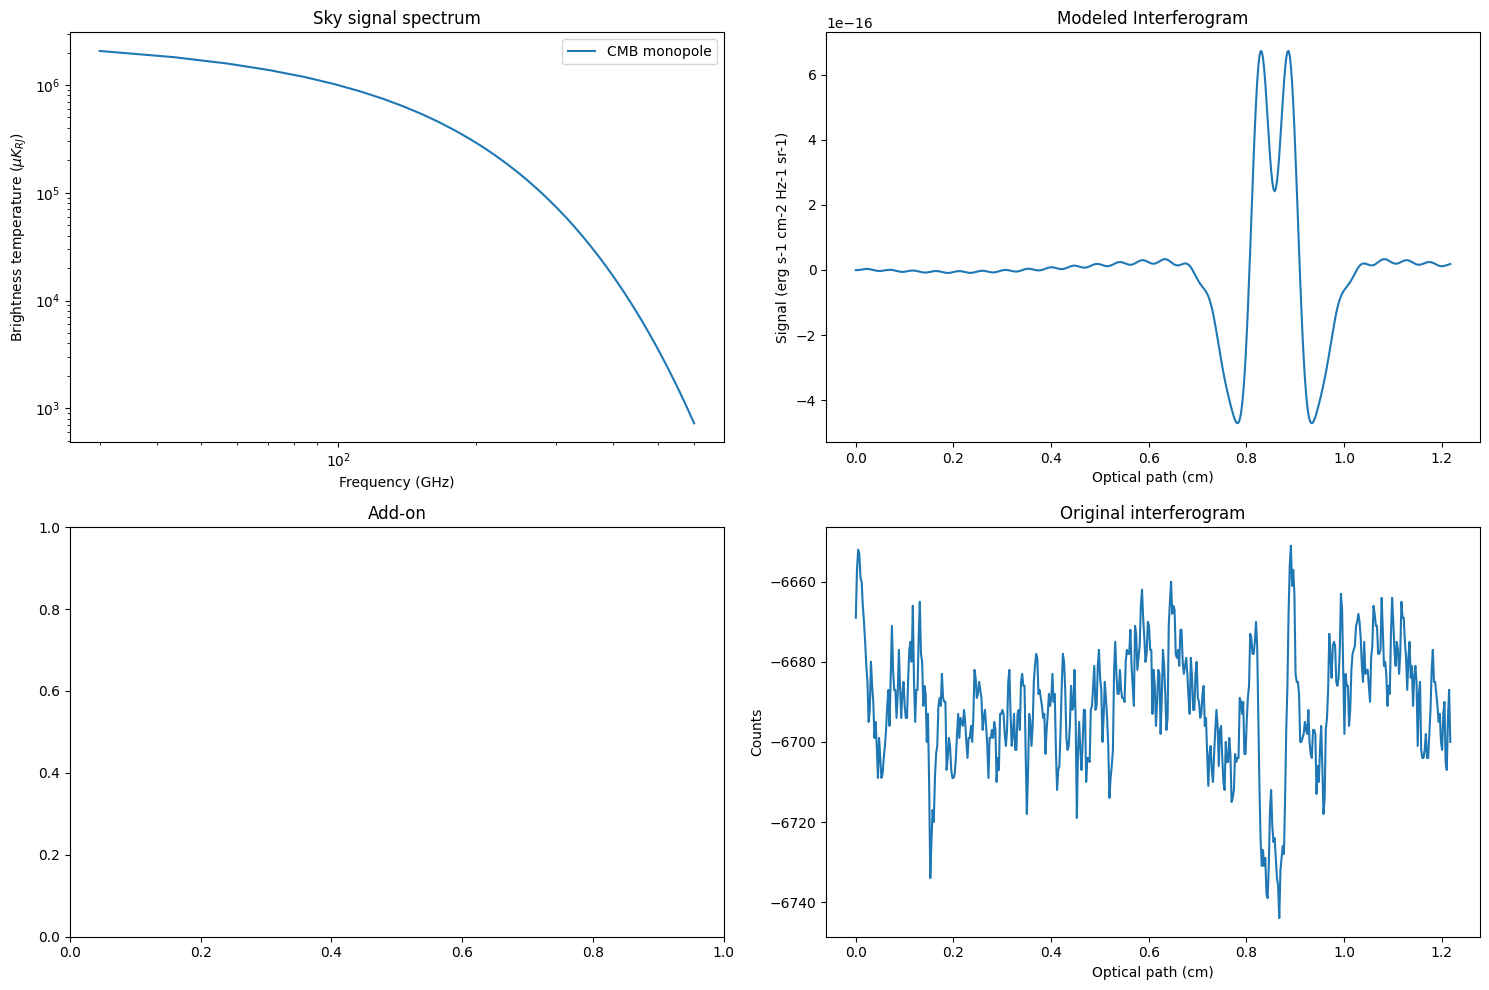

In [10]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_lowf, bb_cmb, label="CMB monopole")
# ax[0,0].plot(f_GHz, bb_cmb - t_cmb, label="CMB")
ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
ax[0,1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Modeled Interferogram")

ax[1,1].plot(x, original_ifg)
ax[1,1].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

CMB anisotropies

In [11]:
dt = 3.5 * u.mK

cmb_anisotropies = bb_cmb * np.exp(c.h * f_lowf / (c.k_B * t_cmb)) / (np.exp(c.h * f_lowf / (c.k_B * t_cmb)) - 1) * c.h * f_lowf / c.k_B / t_cmb ** 2 * dt
cmb_anisotropies = cmb_anisotropies.to(u.uK, equivalencies=u.brightness_temperature(f_lowf))

In [12]:
sky = bb_cmb + cmb_anisotropies

diff, ifg = transform_to_ifg(sky, bb_ical)

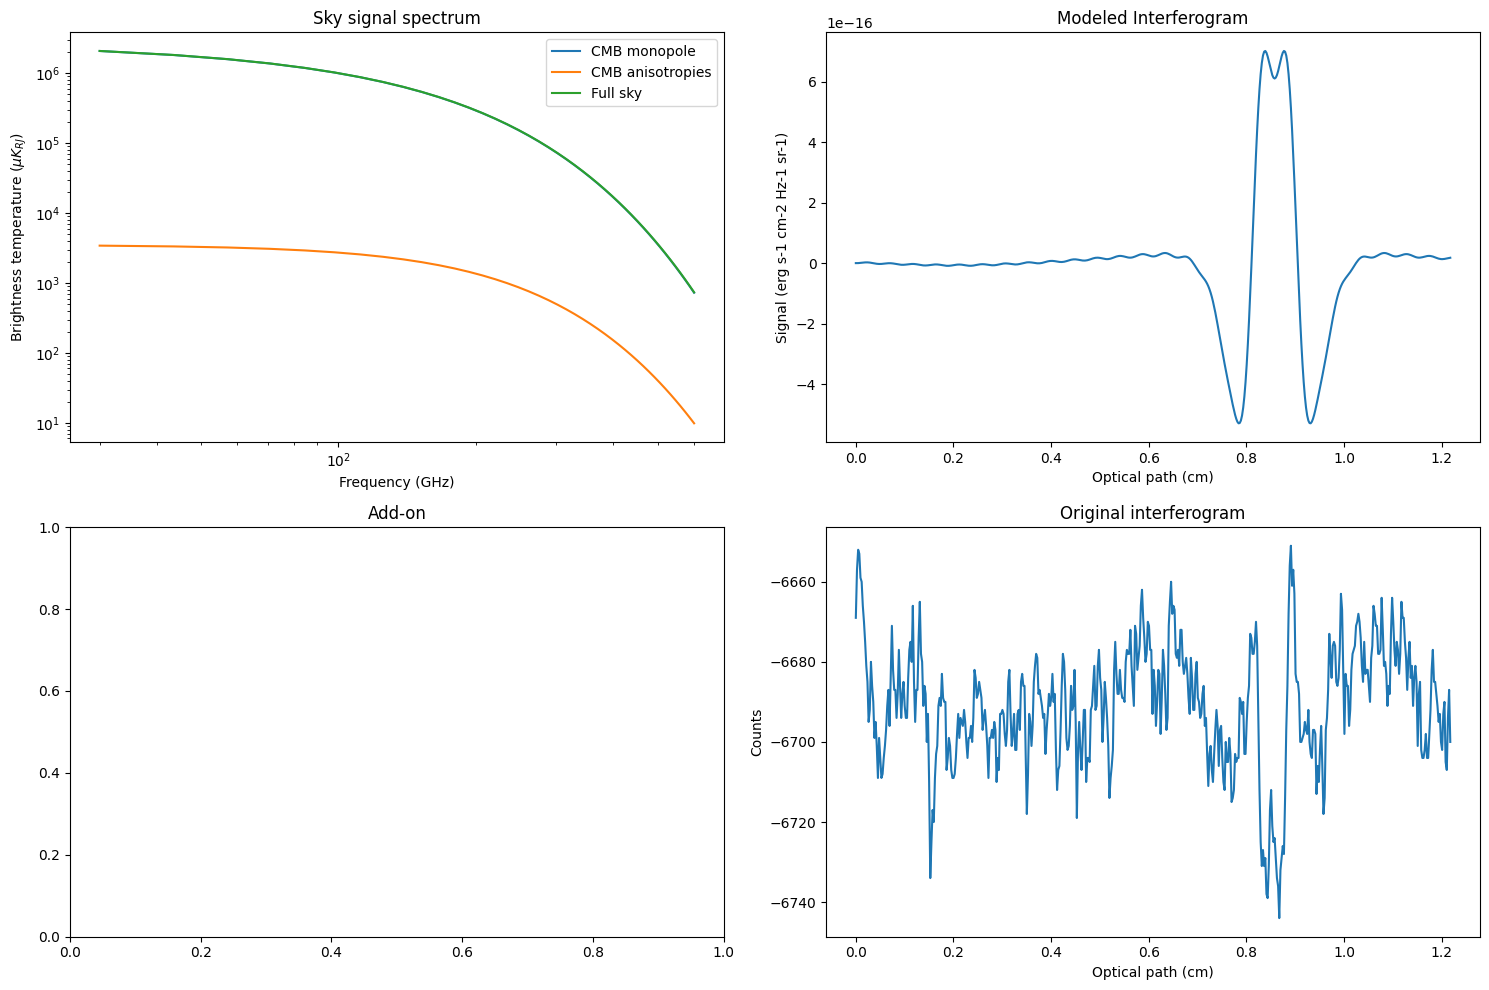

In [13]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_lowf, bb_cmb, label="CMB monopole")
ax[0,0].plot(f_lowf, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_lowf, sky, label="Full sky")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
ax[0,1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Modeled Interferogram")

ax[1,1].plot(x, original_ifg)
ax[1,1].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Synchrotron radiation

In [14]:
# beta_synch = -3.07 
# nu0_synch = 408 * u.MHz

# # S_v0 = 1.0 * u.erg / u.s / u.cm**2 / u.Hz / u.sr
# amplitude_synch = 30 * u.K

# synchrotron = amplitude_synch * (f_GHz / nu0_synch)**beta_synch
# synchrotron = synchrotron.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))
# # synchrotron = synchrotron.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))

In [15]:
# sky = bb_cmb + cmb_anisotropies + synchrotron

# _, ifg = transform_to_ifg(sky, bb_ical)

In [16]:
# fig, ax = plt.subplots(2,2, figsize=(15,10))

# ax[0,0].plot(f_GHz, bb_cmb, label="CMB monopole")
# ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
# ax[0,0].plot(f_GHz, sky, label="Total sky signal")
# ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
# ax[0,0].set_title("Sky signal spectrum")
# ax[0,0].set_ylim(1e-10,1e7)
# ax[0,0].set_yscale("log")
# ax[0,0].set_xscale("log")
# ax[0,0].legend()

# ax[1,0].set_title("Add-on")

# ax[0,1].plot(x, ifg)
# # ax[1].set_xlabel("Optical path (cm)")
# ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
# ax[0,1].set_title("Interferogram")
# # ax[0,1].set_ylim(-2e-14,5e-14)

# ax[1,1].plot(x, original_ifg)
# # ax[2].set_xlabel("Optical path (cm)")
# ax[1,1].set_ylabel("Counts")
# ax[1,1].set_title("Original interferogram")

# plt.tight_layout()
# plt.show()

Thermal dust

In [17]:
# nu0_dust = 353 * u.GHz # Planck 2013 results. XI. All-sky model of thermal dust emission
nu0_dust = 1800 * u.GHz # Explanatory Supplement
beta_dust = 1.62
t_dust = 19.7 * u.K
optical_depth_nu0 = 9.6 * 10**(-7)

dust_bb = BlackBody(t_dust)
dust = optical_depth_nu0 * (f_lowf / nu0_dust)**beta_dust * dust_bb(f_lowf) 
dust = dust.to(u.uK, equivalencies=u.brightness_temperature(f_lowf))

In [18]:
sky = bb_cmb + cmb_anisotropies + dust # + synchrotron

diff, ifg = transform_to_ifg(sky, bb_ical)
save_ifg = ifg

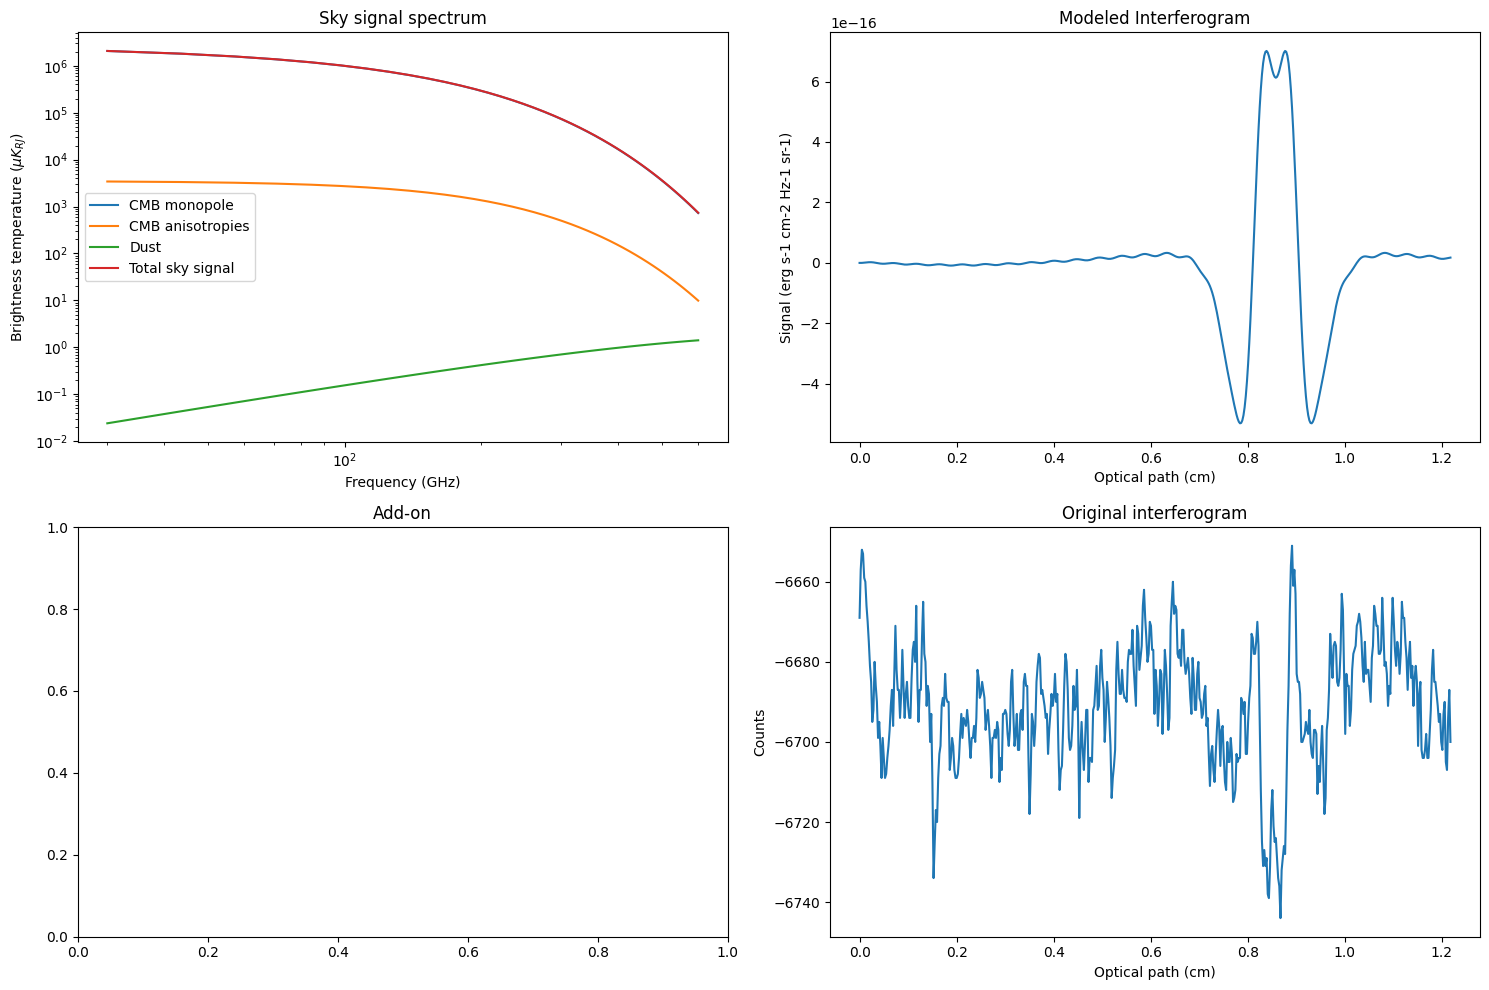

In [19]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_lowf, bb_cmb, label="CMB monopole")
ax[0,0].plot(f_lowf, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_lowf, dust, label="Dust")
ax[0,0].plot(f_lowf, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
ax[0,1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Modeled Interferogram")

ax[1,1].plot(x, original_ifg)
ax[1,1].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Spectral lines

In [20]:
# line_frequencies_GHz = [115.27, 230.54, 345.80, 424.75, 461.04, 492.23, 556.89, 576.27] * u.GHz # page 115 of the explanatory supplement
# line_frequencies_icm = line_frequencies_GHz.to("cm-1", equivalencies=u.spectral())
# sigma = 5.37 * u.mm

# line_intensity = []

# for line_frequency in line_frequencies_icm:
#     intensity = (np.cos(2 * np.pi * line_frequency * (x - x0) * u.rad) * np.exp(-1/2 * (line_frequency / f_nyquist * x / sigma) ** 2)) * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)
#     line_intensity.append(intensity)

In [21]:
# for i in range(len(line_intensity)):
#     ifg = ifg + line_intensity[i]

In [22]:
# fig, ax = plt.subplots(2,2, figsize=(15,10))

# ax[0,0].plot(f_lowf, bb_cmb, label="CMB monopole")
# ax[0,0].plot(f_lowf, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_lowf, sky, label="Full sky")
# ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
# ax[0,0].set_title("Sky signal spectrum")
# ax[0,0].set_yscale("log")
# ax[0,0].set_xscale("log")
# ax[0,0].legend()

# ax[1,0].set_title("Add-on")
# for i in range(len(line_intensity)):
#     ax[1,0].plot(x, line_intensity[i])
# ax[1,0].set_xlabel("Optical path (cm)")
# ax[1,0].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
# ax[1,0].set_title("Spectral lines")

# ax[0,1].plot(x, ifg)
# ax[0,1].set_xlabel("Optical path (cm)")
# ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
# ax[0,1].set_title("Modeled Interferogram")

# ax[1,1].plot(x, original_ifg)
# ax[1,1].set_xlabel("Optical path (cm)")
# ax[1,1].set_ylabel("Counts")
# ax[1,1].set_title("Original interferogram")

# plt.tight_layout()
# plt.show()

## Instrument effects

Dealing with fits file

In [23]:
data_lowf = fits.open('FIRAS_CALIBRATION_MODEL_LLSS.FITS')
data_high = fits.open('FIRAS_CALIBRATION_MODEL_LHSS.FITS')

In [24]:
len(data_lowf)
# data_lowf[0].header
data_lowf[1].header

XTENSION= 'BINTABLE'           / Extension type is Binary Table                 
BITPIX  =                    8 / Binary data                                    
NAXIS   =                    2 / Data are in a table                            
NAXIS1  =                15600 / Number of 8 bit bytes in each row              
NAXIS2  =                    1 / Number of rows                                 
PCOUNT  =                    0 / Number of bytes of data following table        
GCOUNT  =                    1 / Group count (always 1 for bintable extensions) 
TFIELDS =                   45 / Number of fields (columns) in the table        
COMMENT                                                                         
COMMENT                                                                         
COMMENT    FIRAS Calibration Model Solution                                     
COMMENT    Project Dataset Record Structure                                     
COMMENT                     

In [25]:
otf_real_lowf = data_lowf[1].data["RTRANSFE"][0]
otf_im_lowf = data_lowf[1].data["ITRANSFE"][0]
otf_lowf = np.sqrt(otf_real_lowf**2 + otf_im_lowf**2)

otf = otf_lowf[:43]

In [26]:
# otf_real_high = data_high[1].data["RTRANSFE"][0]
# otf_im_high = data_high[1].data["ITRANSFE"][0]
# otf_high = np.sqrt(otf_real_high**2 + otf_im_high**2)

# plt.plot(otf_high)
# plt.yscale("log")
# plt.show()

In [27]:
# otf_total = otf_lowf + otf_high

# plt.plot(nu[:len(otf_total)],otf_total)
# plt.yscale("log")

In [28]:
diff = diff * otf

ifg = np.zeros(len(x))

for i in range(len(x)):
    # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu_lowf.value * (x[i] - x0).value))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

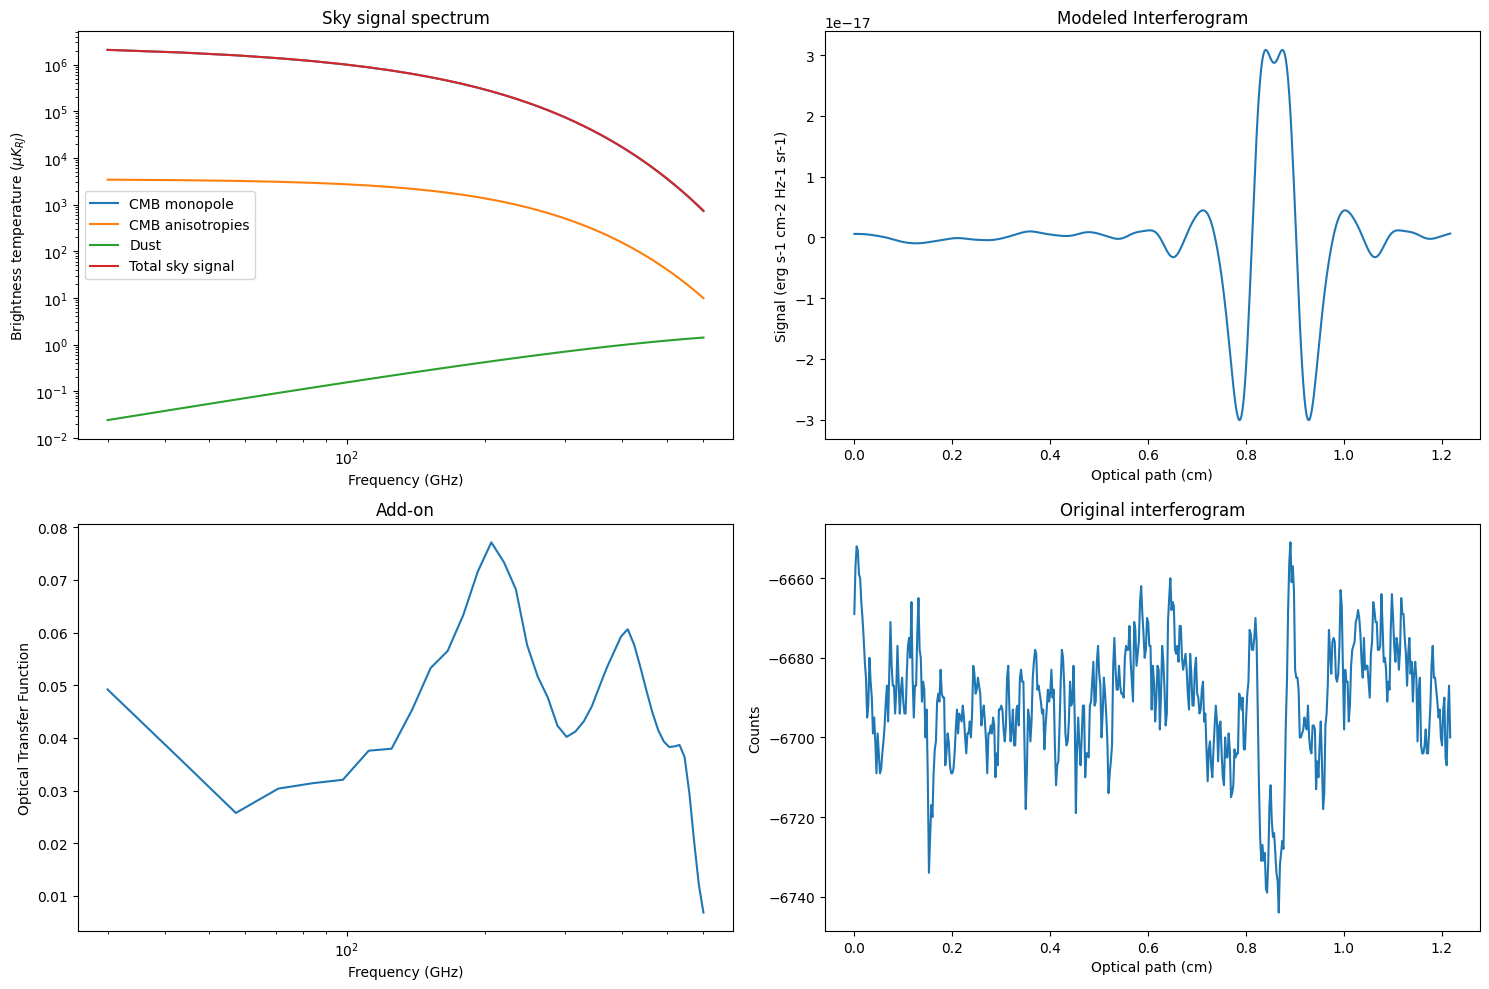

In [29]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_lowf, bb_cmb, label="CMB monopole")
ax[0,0].plot(f_lowf, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_lowf, dust, label="Dust")
ax[0,0].plot(f_lowf, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].legend()

ax[1,0].plot(f_lowf, otf)
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Optical Transfer Function")
ax[1,0].set_xscale("log")
ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
ax[0,1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Modeled Interferogram")

ax[1,1].plot(x, original_ifg)
ax[1,1].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Phase correction

In [30]:
psi = 1e-5 * u.cm
phase_correction = np.exp(1j * nu_lowf * psi)

In [31]:
diff = diff * phase_correction

ifg = np.zeros(len(x))

for i in range(len(x)):
    # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu_lowf.value * (x[i] - x0).value))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

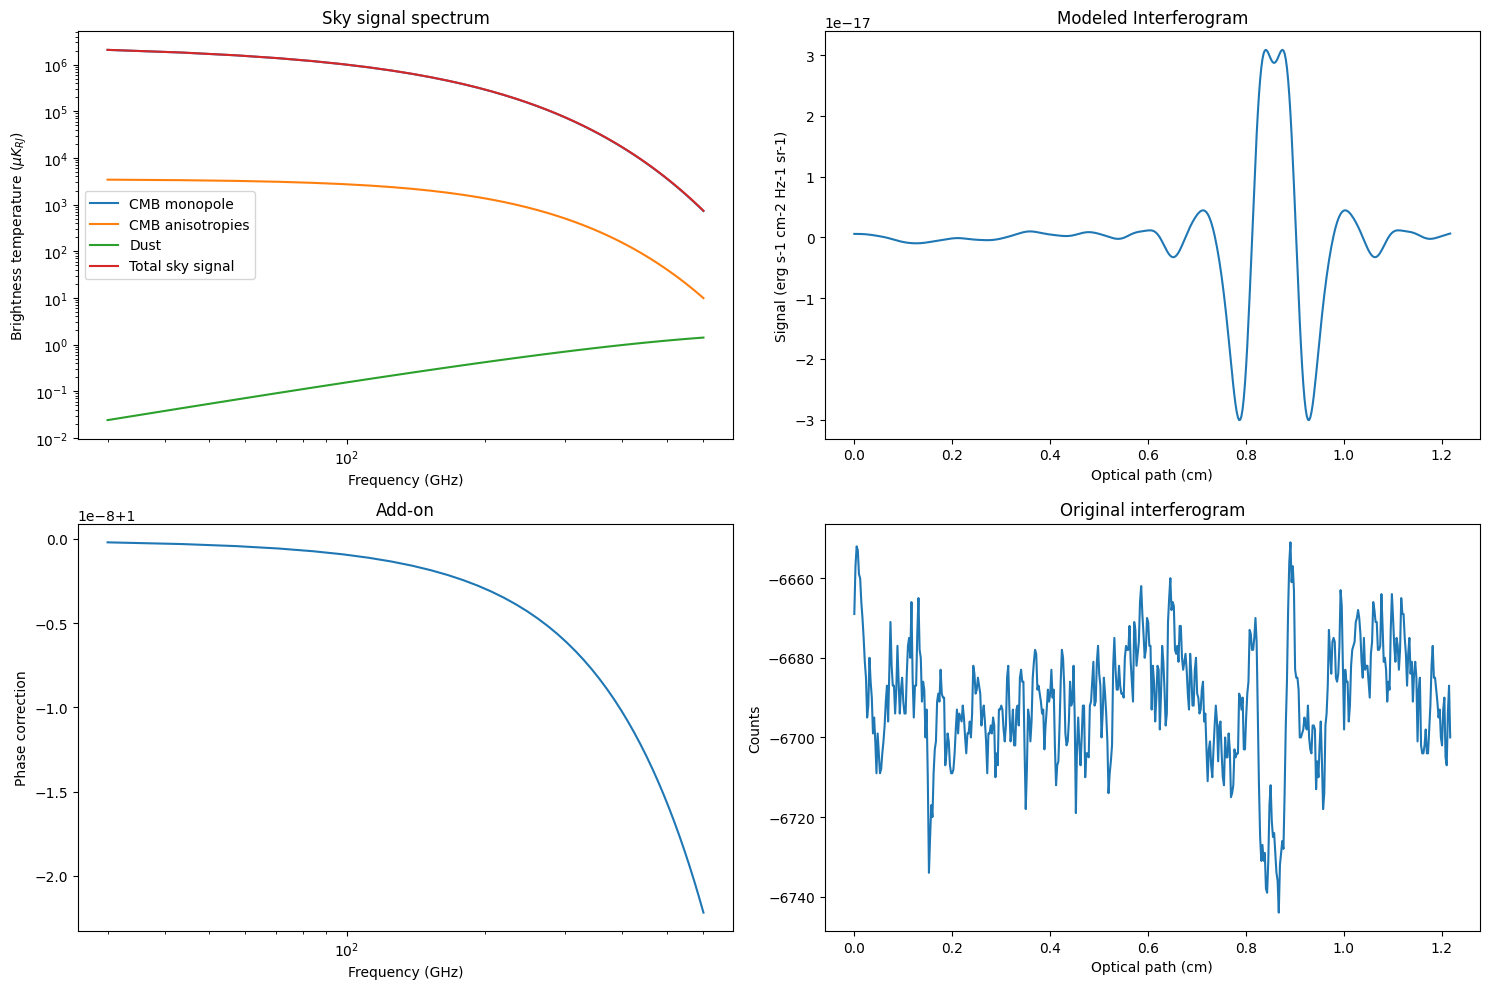

In [32]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_lowf, bb_cmb, label="CMB monopole")
ax[0,0].plot(f_lowf, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_lowf, dust, label="Dust")
ax[0,0].plot(f_lowf, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].legend()

ax[1,0].plot(f_lowf, phase_correction)
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Phase correction")
ax[1,0].set_xscale("log")
ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
ax[0,1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Modeled Interferogram")

ax[1,1].plot(x, original_ifg)
ax[1,1].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Harmonic correction

From apply_model2:

```python
specs[:, idxs] = (B[:, idxs] * vspecs[:, idxs] - param[9] * harm_3 - param[10] * harm_2 - 
                      sec_vib * sec_vib_corr - primary_vib[:, None] * prim_vib_corr) / denom

vspec = vspec = np.fft.rfft(rifg)
vspec[1:speclen] *= np.exp(jvals*phase_shift) / (spec_norm * etfl[1:speclen])
```


In [33]:
param9 = data_lowf[1].data["OPTPARM2"][0]
# harm_3 = 
param10 = data_lowf[1].data["OPTPARM_"][0]
# harm_2 = 

Vibration correction

In [34]:
# data_lowf[1].header

In [35]:
sec_vib = data_lowf[1].data["OPTPARM8"][0]
# sec_vib_corr =

primary_vib = 0
time = util.time_since_apco(data_ll["ct_head/time"][ifg_ind])
for j in range(4, -1, -1):
    primary_vib = primary_vib * time + data_lowf[1].data[f"OPTPARM{3+j}"][0]
# prim_vib_corr =

Adding ETF

In [36]:
# Got the samprate directly from the file /mn/stornext/d5/data/duncanwa/FIRAS/firas_analysis_original/firas_pipeline/reference/fex_samprate.txt
etf = elex_transfcnl(samprate=681.43, nfreq=512)

# etf = etf[np.random.randint(0, len(etf))]
etf = etf[erecno]

print(diff)

# We multiply the spectrum of the radiation sources by the ETF, as described in page 461 of Fixsen 1993
diff = diff / etf[:len(diff)]

# print(diff)

ifg = np.zeros(len(x))

for i in range(len(x)):
    # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu_lowf.value * (x[i] - x0).value))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)


[ 8.41290659e-19+1.68258132e-23j  1.08525629e-18+2.66298833e-23j
  1.12632474e-18+3.27487366e-23j  1.68367873e-18+5.65945454e-23j
  2.02791256e-18+7.73679061e-23j  2.26304161e-18+9.66078319e-23j
  2.76222550e-18+1.30452314e-22j  2.78740124e-18+1.44290174e-22j
  3.20985815e-18+1.80724644e-22j  3.51965366e-18+2.14138808e-22j
  3.37599874e-18+2.20718578e-22j  3.31747616e-18+2.31946737e-22j
  3.18120905e-18+2.36855329e-22j  2.80298202e-18+2.21414207e-22j
  2.08473308e-18+1.74138276e-22j  1.42856353e-18+1.25810911e-22j
  8.12672914e-19+7.52583881e-23j  4.12885059e-19+4.01092546e-23j
  1.28838933e-19+1.31005682e-23j -7.47664632e-20-7.94166571e-24j
 -2.18334450e-19-2.41821780e-23j -3.43496838e-19-3.96035969e-23j
 -4.55014955e-19-5.45259211e-23j -5.58342130e-19-6.94416392e-23j
 -6.57350588e-19-8.47384075e-23j -7.36639776e-19-9.83022767e-23j
 -7.89899488e-19-1.08994084e-22j -8.24550382e-19-1.17517086e-22j
 -8.23087153e-19-1.21043609e-22j -7.52196034e-19-1.14031697e-22j
 -6.60908395e-19-1.031917

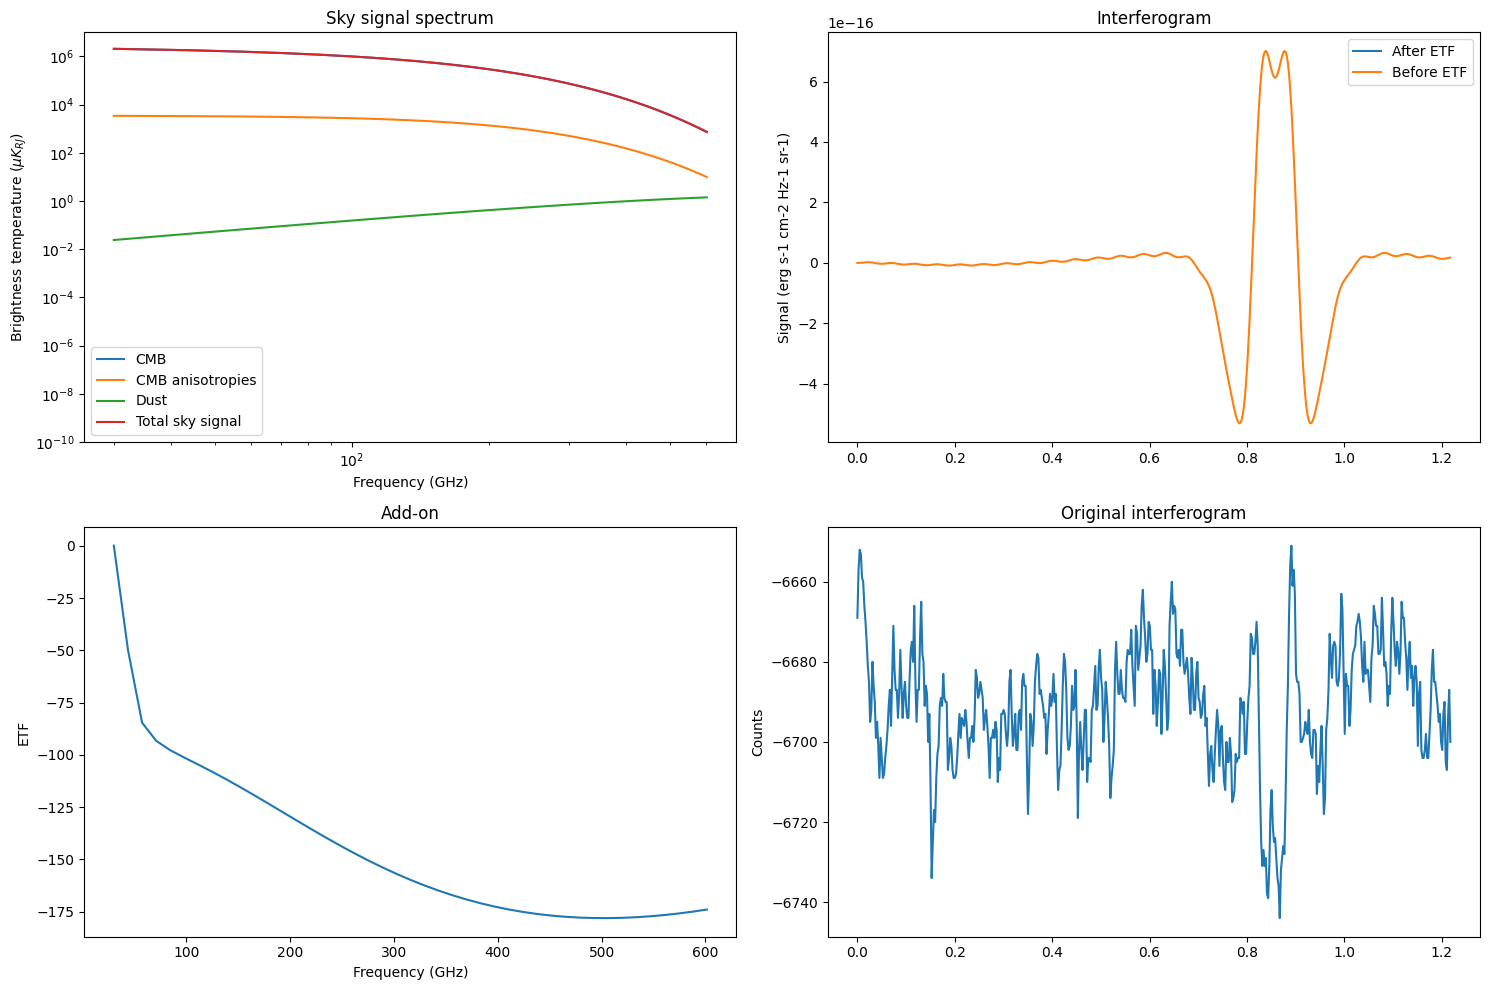

In [37]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_lowf, bb_cmb, label="CMB")
ax[0,0].plot(f_lowf, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_lowf, dust, label="Dust")
ax[0,0].plot(f_lowf, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(f_lowf, etf[:len(f_lowf)])
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("ETF")
ax[1,0].set_title("Add-on")


ax[0,1].plot(x[2:], ifg[2:], label="After ETF")
ax[0,1].plot(x, save_ifg, label="Before ETF")
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)
ax[0,1].legend()

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Bolometer model

In [38]:
# S0 = 1e9 * u.A
# omega = 2 * np.pi * f_GHz
# tau = 1e-3 * u.s

# bolometer = S0 / (1 + 1j * omega * tau)

In [39]:
# coadd_recs = read_coadd(args.fil_path, args.channel, args.scan_mode, config, input_type=args.input, quality=quality)
# vspec_rec  = produce_spectra(coadd_recs[j], chan, scan_mode, apodl_all, etfl_all) 
# bol_volt = vspec_rec['coad_spec_data']['bol_volt']

# tbol, qrad, S0, tau = calc_responsivity(bol_volt, cmd_bias, tdet, model['bolparm'])

In [40]:
bol_volt = data_orig_eng["en_analog/group1/bol_volt"][eng_id, 3]
Tbol = (data_orig_eng["en_analog/grt/a_lo_bol_assem"][eng_id, 3] + data_orig_eng["en_analog/grt/b_lo_bol_assem"][eng_id, 3]) / 2
cmd_bias = data_orig_eng["en_stat/bol_cmd_bias"][eng_id, 3]

In [41]:
rscale = 1.0e-7 

# RL = 4.0e7 
RL = 40e6 # Calibration of the COBE FIRAS instrument (Fixsen et al. 1994) - 40 MOhm

# set by me
Jo = 0
Jg = 1.0

V = (bol_volt - Jo) / Jg

G1 = 1.0e-8
beta = 1
G = G1*Tbol**beta
rho = 1

X = V*rho

H = Tbol / X * np.tanh(X/Tbol)

T0 = 100.0

DT = 1.0/H - 1.0 - 0.5*np.sqrt(T0/Tbol)

R = RL*V / (cmd_bias - V)
Z = (G*Tbol*R + DT*V**2) / (G*Tbol*R/H - DT*V**2)

S0 = rscale * R * (Z-H) / (V * (Z*R/RL + 1.0) * (H + 1.0))

In [42]:
C3 = 1.0e-10
C1 = 1.0e-10

C = C3*Tbol**3 + C1*Tbol

tau = C/G * (Z+1.0) * (R*H + RL) / ((Z*R + RL) * (H + 1.0))

In [43]:
omega = 2 * np.pi * f_GHz

bolometer = S0 / (1 + 1j * omega.value * tau)

In [44]:
diff = diff / bolometer

ifg = np.zeros(len(x))

for i in range(len(x)):
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

ValueError: operands could not be broadcast together with shapes (43,) (512,) 

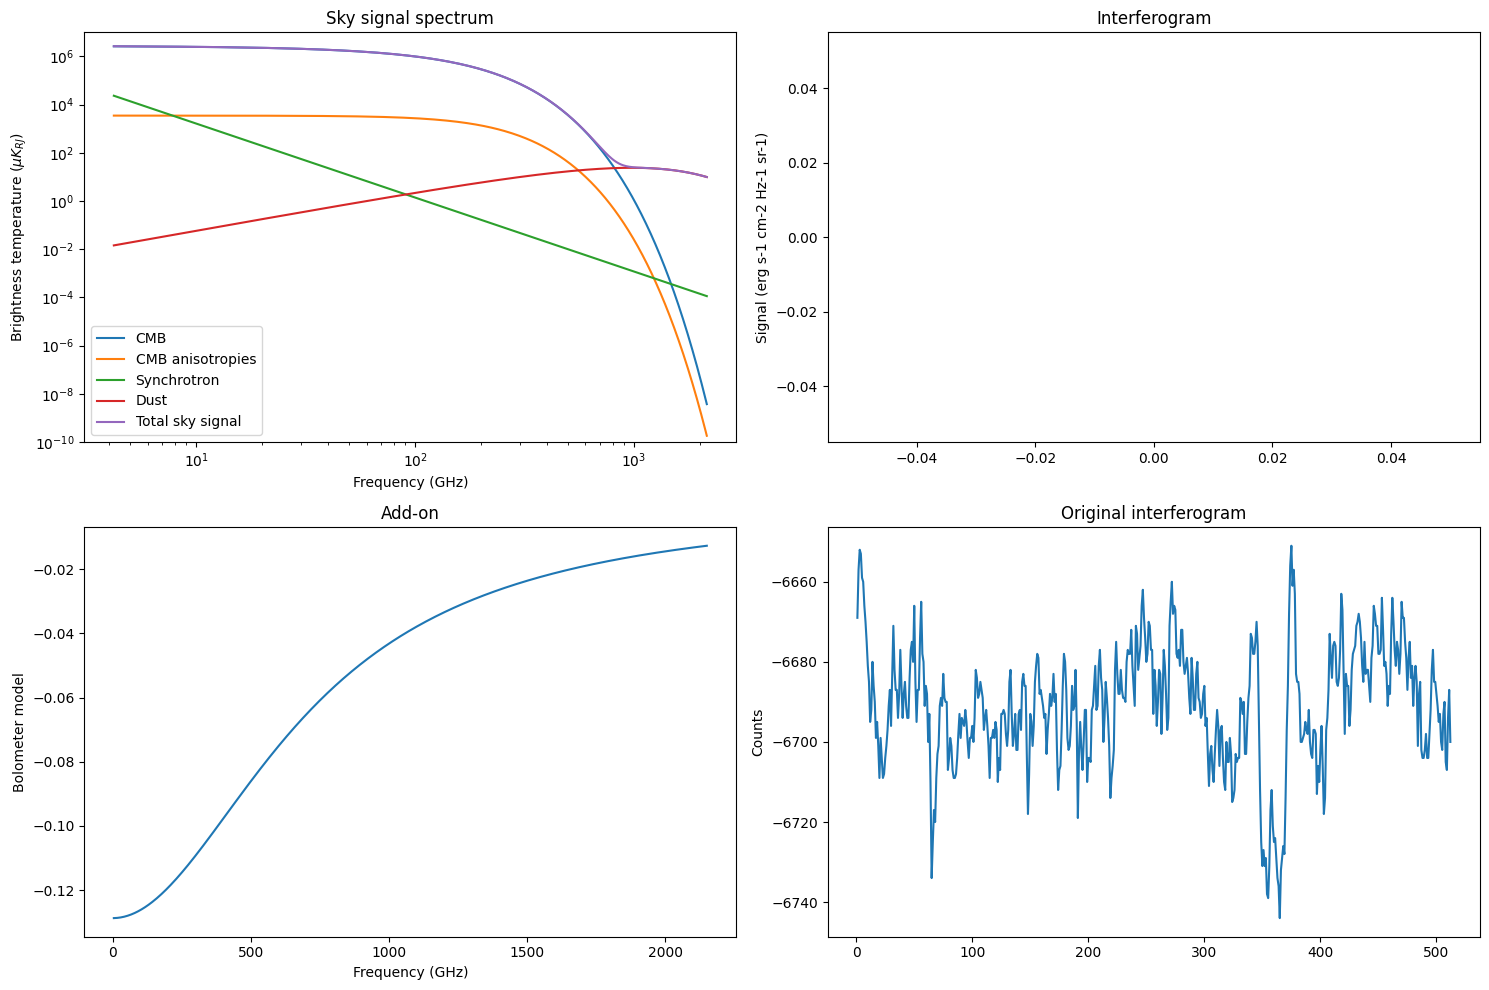

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(f_GHz, bolometer)
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Bolometer model")
ax[1,0].set_title("Add-on")


ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

1/f noise

In [ ]:
kmin = 0
kmax = 512

ck = [0]
cnk = []
for k in range(1, kmax):
    fk = (k * len(x) / (2*np.pi))
    phase = np.random.uniform(0, 2*np.pi)
    ck.append(1/np.abs(fk) * np.cos(phase) * 1e-12)

diff = diff.value + ck

ifg = np.zeros(len(x))

for i in range(len(x)):
    ifg[i] = np.sum(diff * np.cos(2 * np.pi * nu * (x[i] - x0)))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

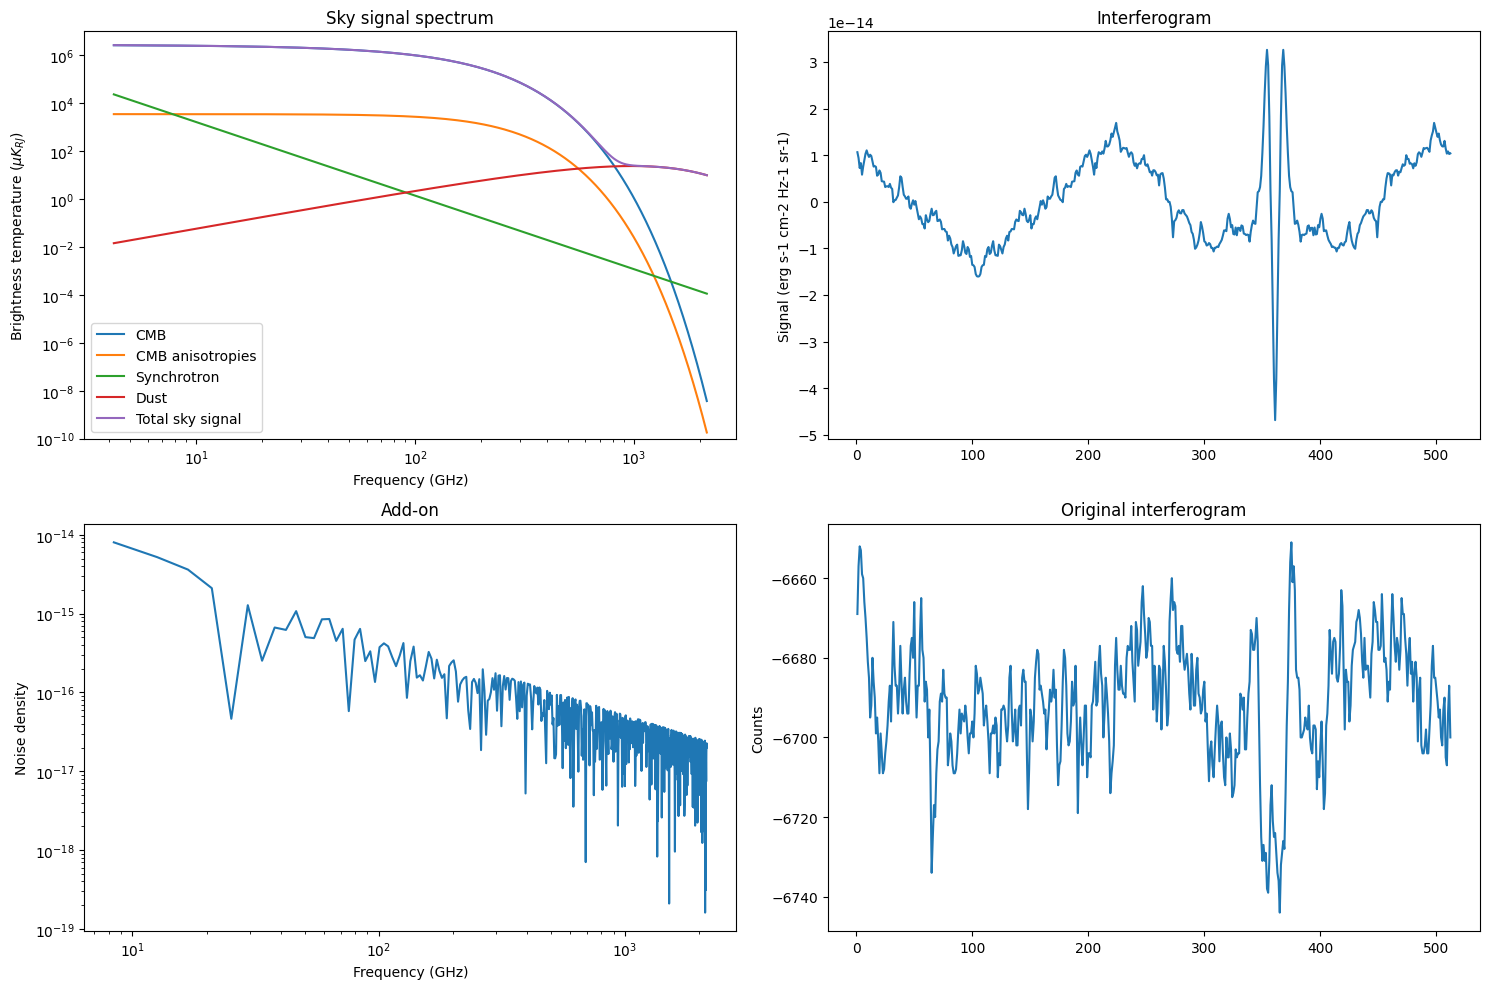

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

# ax[1,0].plot(x, noise1f)
ax[1,0].plot(f_GHz[1:], np.abs(ck[1:]))
ax[1,0].set_title("Add-on")
ax[1,0].set_xscale("log")
ax[1,0].set_yscale("log")
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Noise density")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Adding white noise

In [ ]:
# estimation for level of white noise
max_signal = 50
max_noise = 5

noise_level = max(abs(ifg)).value * max_noise / max_signal

noise = np.random.normal(0, noise_level, len(x)) * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

ifg = ifg + noise

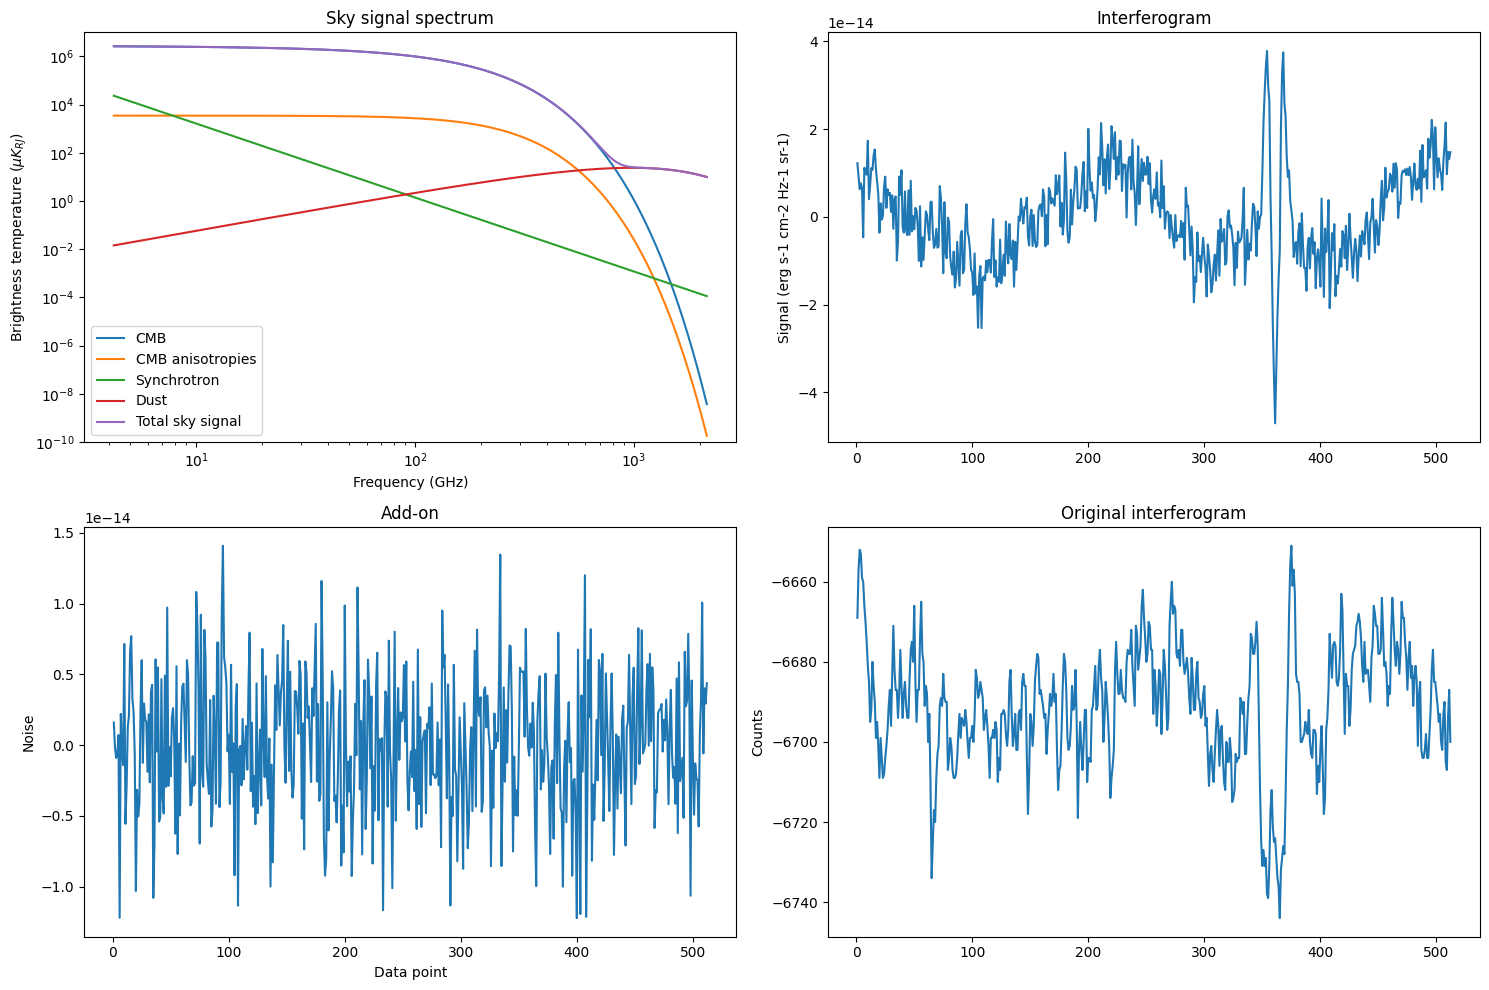

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(x, noise)
ax[1,0].set_title("Add-on")
ax[1,0].set_xlabel("Data point")
ax[1,0].set_ylabel("Noise")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Defocusing correction

In [ ]:
# # add fourth order polynomial trend
# a = 1e-30
# b = 1e-30
# c = 1e-30
# d = 1e-30
# e = 1e-30

# # defocusing_correction = a + b * (x-x0) + c * (x-x0)**2 + d * (x-x0)**3 + e * (x-x0)**4
# defocusing_correction = np.cos(2 * np.pi * x / 250) * 5e-13

# ifg = ifg + defocusing_correction * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

In [ ]:
# fig, ax = plt.subplots(2,2, figsize=(15,10))

# ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
# ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
# ax[0,0].plot(f_GHz, dust, label="Dust")
# ax[0,0].plot(f_GHz, sky, label="Total sky signal")
# ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
# ax[0,0].set_title("Sky signal spectrum")
# ax[0,0].set_xscale("log")
# ax[0,0].set_yscale("log")
# ax[0,0].set_ylim(1e-10,1e7)
# ax[0,0].legend()

# ax[1,0].plot(x, defocusing_correction)
# # ax[1,0].set_xlabel("Optical path (cm)")
# ax[1,0].set_title("Defocusing correction")
# ax[1,0].set_xlabel("Data point")

# ax[0,1].plot(x, ifg)
# # ax[1].set_xlabel("Optical path (cm)")
# ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
# ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

# ax[1,1].plot(x, original_ifg)
# # ax[2].set_xlabel("Optical path (cm)")
# ax[1,1].set_ylabel("Counts")
# ax[1,1].set_title("Original interferogram")

# plt.tight_layout()
# plt.show()

Adding cosmic ray glitches

In [ ]:
n_glitches = 10
x_glitches = np.random.randint(0, len(x), n_glitches)

max_glitch = 10
glitch_level = max(abs(ifg)).value * max_glitch / max_signal

glitches = np.random.normal(0, glitch_level, n_glitches) 
glitch_curve = np.zeros(len(x))

for i, j in zip(x_glitches, range(len(glitches))):
    ifg[i] = ifg[i] + glitches[j] * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)
    glitch_curve[i] = glitches[j]


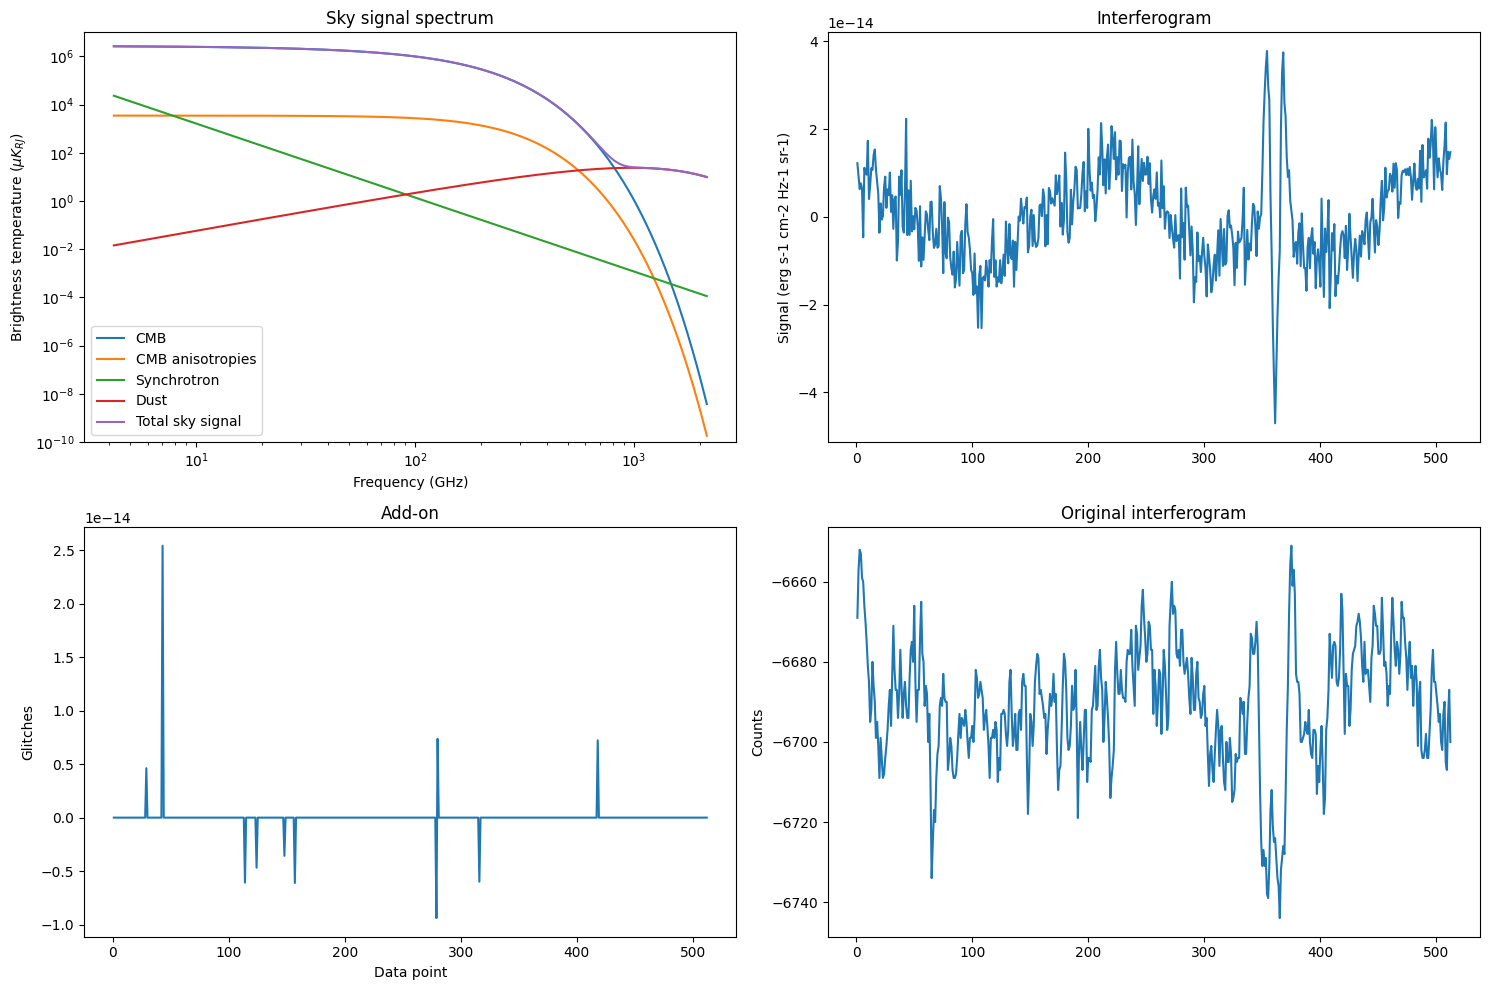

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(x, glitch_curve)
ax[1,0].set_title("Add-on")
ax[1,0].set_xlabel("Data point")
ax[1,0].set_ylabel("Glitches")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()